In [ ]:
import numpy as np
import pandas as pd

import re

import os.path
from os import path

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.cluster import KMeans

import wrangle as wr
import preprocessing as pr
import explore as ex
import model as mo

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def acquire_building_permits():
    """
    Docstring
    """
    
    # conditional
    if path.exists("building_permits.csv"):
        
        # read csv
        df = pd.read_csv("building_permits.csv", index_col=0)
        
    else:
    
        # create original df with 2019 data
        df = pd.read_csv("https://www2.census.gov/econ/bps/Metro/ma2019a.txt", sep=",", header=1)

        # rename columns
        rename_columns(df)

        for i in range(1980, 2019):

            # read the txt file at url where i is the year in range
            year_df = pd.read_csv(
                f"https://www2.census.gov/econ/bps/Metro/ma{i}a.txt",
                sep=",",
                header=1,
                names=df.columns.tolist(),
            )
            
            # append data to global df variable
            df = df.append(year_df, ignore_index=True)

        # make moncov into bool so that the null observations of this feature are not considered in the dropna below
        df["moncov"] = np.where(df.moncov == "C", 1, 0)

        # dropna inplace
        df.dropna(inplace=True)
        
        # chop off the succeding two digits after the year for survey_date
        df["survey_date"] = df.survey_date.astype(str).apply(lambda x: re.sub(r"\d\d$", "", x))
        
        # add a preceding "19" to any years where the length of the observation is 2 (e.i., "80"-"97")
        df["survey_date"] = df.survey_date.apply(lambda x: "19" + x if len(x) == 2 else x)
        
        # turn survey_date back into an int
        df["survey_date"] = df.survey_date.astype(int)
        
        # turn moncov back into a bool
        df["moncov"] = df.moncov.astype(bool)
        
        # sort values by survey_date
        df.sort_values(by=["survey_date"], ascending=False, inplace=True)

        # reset index inplace
        df.reset_index(inplace=True)

        # drop former index inplace
        df.drop(columns=["index"], inplace=True)
        
        # write df to disk as csv
        df.to_csv("building_permits.csv")
    
    return df

In [ ]:
def rename_columns(df):
    """
    Docstring
    """
    
    # rename columns inplace
    df.rename(
        columns={
            "Date": "survey_date",
            "Code": "csa_code",
            "Code.1": "cbsa_code",
            "Unnamed: 3": "moncov",
            "Name": "cbsa_name",
            "Bldgs": "one_unit_bldgs_est",
            "Units": "one_unit_units_est",
            "Value": "one_unit_value_est",
            "Bldgs.1": "two_units_bldgs_est",
            "Units.1": "two_units_units_est",
            "Value.1": "two_units_value_est",
            "Bldgs.2": "three_to_four_units_bldgs_est",
            "Units.2": "three_to_four_units_units_est",
            "Value.2": "three_to_four_units_value_est",
            "Bldgs.3": "five_or_more_units_bldgs_est",
            "Units.3": "five_or_more_units_units_est",
            "Value.3": "five_or_more_units_value_est",
            "Bldgs.4": "one_unit_bldgs_rep",
            "Units.4": "one_unit_units_rep",
            "Value.4": "one_unit_value_rep",
            "Bldgs.5": "two_units_bldgs_rep",
            "Units.5": "two_units_units_rep",
            "Value.5": "two_units_value_rep",
            "      Bldgs": "three_to_four_units_bldgs_rep",
            "Units.6": "three_to_four_units_units_rep",
            "Value.6": "three_to_four_units_value_rep",
            "Bldgs.6": "five_or_more_units_bldgs_rep",
            "Units.7": "five_or_more_units_units_rep",
            "Value.7": "five_or_more_units_value_rep",
        },
        inplace=True,
        )
    
    return df


In [4]:
df = acquire_building_permits()

In [5]:
df.shape

(14149, 29)

In [6]:
def prep_building_permits(df_model):
    df_model["city"] = df_model.cbsa_name.str.split("  ", 1, expand = True)[0]
    df_model["state"] = df_model.cbsa_name.str.split("  ", 1, expand = True)[1]
    df_model["major_city"] = df_model.city.str.split("-", 1, expand=True)[0]
    df_model["major_state"] = df_model.state.str.split("-", 1, expand=True)[0]
    df_model["metropolitan_area"] = df_model.state.str.split("-", 1, expand=True)[1]
    df_model["metropolitan_area"] = df_model.major_state.str.split(" ", 1, expand=True)[1]
    df_model["major_state"] = df_model.major_state.str.split(" ", 1, expand=True)[0]
    df_model = df_model.groupby(["major_city","major_state", "survey_date"]).sum().reset_index()
    return df_model

In [9]:
df_model = prep_building_permits(df)

In [10]:
df_model.major_city.value_counts().value_counts()

23    236
6      67
17     62
46     11
11      7
40      6
10      4
13      3
2       2
1       2
22      2
29      2
21      1
69      1
16      1
15      1
12      1
34      1
7       1
52      1
63      1
86      1
Name: major_city, dtype: int64

In [11]:
df_model.survey_date.min()

1997

In [12]:
df_model.survey_date.max()

2019

In [13]:
# pd.set_option('display.max_rows', None)

In [14]:
df_model.major_city

0       Abilene
1       Abilene
2       Abilene
3       Abilene
4       Abilene
         ...   
8264       Yuma
8265       Yuma
8266       Yuma
8267       Yuma
8268       Yuma
Name: major_city, Length: 8269, dtype: object

In [15]:
mask = ((df_model.major_city.value_counts() == 23) | (df_model.major_city.value_counts() == 46))
not_mask = df_model.major_city.value_counts() != 23

In [16]:
len(df_model.major_city.value_counts()[mask])

247

In [17]:
df_model.major_city.value_counts()[mask].sort_index()

Abilene        23
Akron          23
Albuquerque    23
Alexandria     23
Allentown      23
               ..
Yakima         23
York           23
Youngstown     23
Yuba City      23
Yuma           23
Name: major_city, Length: 247, dtype: int64

In [21]:
# city_mask = df_model.groupby(['major_city', 'major_state']).survey_date.agg('count')  == 23

In [33]:
# mask_df = df_model.groupby(['major_city', 'major_state']).survey_date.agg('count')[city_mask].reset_index()

In [41]:
# mask_df = mask_df[['major_city' , 'major_state']]

In [48]:
df_model['city_state'] = df_model.major_city + '_' + df_model.major_state
city_mask = df_model.city_state.value_counts()[df_model.city_state.value_counts() == 23].index.to_list()

In [134]:
def filter_top_cities_building_permits(df):
    """
    This function masks df in two ways:
    city_mask returns cities with only continuously reported data
    threshold_mask returns cities where they had at least one "5 or more unit" building permit for every year
    Returns 130 cities for modeling
    """
    df["city_state"] = df["major_city"] + "_" + df["major_state"]

    city_mask = df.groupby("city_state").survey_date.count()

    city_mask = city_mask[city_mask == 23]

    # apply city mask to shrink the df
    def in_city_mask(x):
        return x in city_mask
    df = df[df.city_state.apply(in_city_mask)]
    
    threshold_mask = df_model.groupby('city_state').five_or_more_units_bldgs_est.agg(lambda x: (x == 0).sum())

    threshold_mask = threshold_mask[threshold_mask < 1].index.tolist()
    
    # apply threshold mask to shrink the df 
    def in_threshold_mask(x):
        return x in threshold_mask
    df = df[df.city_state.apply(in_threshold_mask)]

    df = df.sort_values(["major_city", "major_state", "survey_date"])
    
    return df

In [132]:
df_model = filter_top_cities_building_permits(df_model)

In [135]:
(df_model['five_or_more_units_bldgs_rep'] == df_model['five_or_more_units_bldgs_est']).mean()

0.525418060200669

In [107]:
explore_df = df_model[['city_state','five_or_more_units_bldgs_est', 'five_or_more_units_units_est',
       'five_or_more_units_value_est']].set_index('city_state')

explore_df

,five_or_more_units_bldgs_est,five_or_more_units_units_est,five_or_more_units_value_est
city_state,,,
Abilene_TX,0.0,0.0,0.0
Abilene_TX,0.0,0.0,0.0
Abilene_TX,0.0,0.0,0.0
Abilene_TX,15.0,192.0,10200.0
Abilene_TX,13.0,192.0,6333.0
...,...,...,...
Yuma_AZ,0.0,0.0,0.0
Yuma_AZ,0.0,0.0,0.0
Yuma_AZ,8.0,68.0,8986.0


In [115]:
mode = lambda x:x.value_counts().index[0]
nu_0 = lambda x: (x == 0).sum()

explore_table = df_model.groupby('city_state').five_or_more_units_bldgs_est.agg(['mean', 'sum', mode, nu_0])
explore_table

,mean,sum,<lambda_0>,<lambda_1>
city_state,,,,
Abilene_TX,3.217391,74.0,0.0,16.0
Akron_OH,19.000000,437.0,1.0,2.0
Albany_GA,4.521739,104.0,1.0,3.0
Albany_NY,56.173913,1292.0,48.0,0.0
Albuquerque_NM,27.043478,622.0,16.0,0.0
...,...,...,...,...
Yakima_WA,6.652174,153.0,0.0,4.0
York_PA,13.260870,305.0,9.0,0.0
Youngstown_OH,5.217391,120.0,0.0,6.0


In [114]:
threshold_mask = explore_table[explore_table['<lambda_1>'] < 1].index.tolist()

In [95]:
explore_table['sum'].describe()

count      274.000000
mean      1310.868613
std       2746.072074
min         20.000000
25%        151.500000
50%        386.500000
75%        947.750000
max      21671.000000
Name: sum, dtype: float64

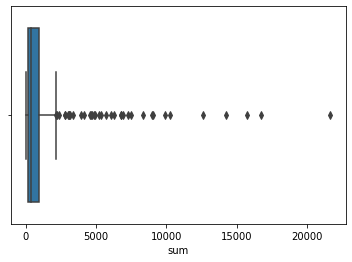

In [96]:
sns.boxplot(explore_table['sum'])

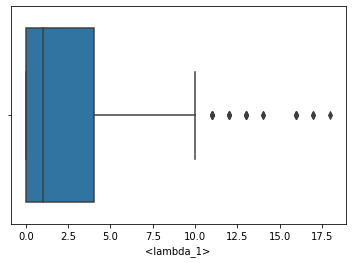

In [100]:
sns.boxplot(explore_table['<lambda_1>'])

In [ ]:
(df_model['five_or_more_units_bldgs_rep'] == df_model['five_or_more_units_bldgs_est']).mean()

In [136]:
df.columns

Index(['survey_date', 'csa_code', 'cbsa_code', 'moncov', 'cbsa_name',
       'one_unit_bldgs_est', 'one_unit_units_est', 'one_unit_value_est',
       'two_units_bldgs_est', 'two_units_units_est', 'two_units_value_est',
       'three_to_four_units_bldgs_est', 'three_to_four_units_units_est',
       'three_to_four_units_value_est', 'five_or_more_units_bldgs_est',
       'five_or_more_units_units_est', 'five_or_more_units_value_est',
       'one_unit_bldgs_rep', 'one_unit_units_rep', 'one_unit_value_rep',
       'two_units_bldgs_rep', 'two_units_units_rep', 'two_units_value_rep',
       'three_to_four_units_bldgs_rep', 'three_to_four_units_units_rep',
       'three_to_four_units_value_rep', 'five_or_more_units_bldgs_rep',
       'five_or_more_units_units_rep', 'five_or_more_units_value_rep', 'city',
       'state', 'major_city', 'major_state', 'metropolitan_area',
       'city_state'],
      dtype='object')

In [139]:
# difference in est vs rep

rep_est = df_model[['city_state', 'five_or_more_units_bldgs_est',
       'five_or_more_units_units_est', 'five_or_more_units_value_est' ,'five_or_more_units_bldgs_rep',
       'five_or_more_units_units_rep', 'five_or_more_units_value_rep']]


In [149]:

dif = (abs(rep_est.five_or_more_units_bldgs_rep - rep_est.five_or_more_units_bldgs_est).sum())
total = rep_est.five_or_more_units_bldgs_est.sum()

perc_dif = dif/total

perc_dif

0.07930700527278597

In [151]:
dif = (abs(rep_est.five_or_more_units_value_rep - rep_est.five_or_more_units_value_est).sum())
total = rep_est.five_or_more_units_value_est.sum()

perc_dif = dif/total

perc_dif

0.035487266652518404

In [153]:
dif = (abs(rep_est.five_or_more_units_units_rep - rep_est.five_or_more_units_units_est).sum())
total = rep_est.five_or_more_units_units_est.sum()

perc_dif = dif/total

perc_dif

0.040841195944314436

In [159]:
df_model = df_model.rename(columns={
    'survey_date': 'year',
    'major_city': 'city',
    'major_state': 'state'
})

In [162]:
def labeling_future_data(df):
    """this function takes in a data frame and returns a boolean column that identifies
    if a city_state_year is a market that should be entered"""
    
    df["five_or_more_units_bldgs_est_2y"] = (df.sort_values(["year"])
                                  .groupby(["city", "state"])[["five_or_more_units_bldgs_est"]]
                                  .pct_change(2)
                                  .shift(-2))
    
    df["five_or_more_units_value_est_2y"] = (df.sort_values(["year"])
                                  .groupby(["city", "state"])[["five_or_more_units_value_est"]]
                                  .pct_change(2)
                                  .shift(-2))
    
    Q3 = df.five_or_more_units_bldgs_est_2y.quantile(.75)
    Q1 = df.five_or_more_units_bldgs_est_2y.quantile(.25)
    upper_fence_quantity = Q3 + ((Q3-Q1)*1.5)
    upper_fence_quantity
    
    Q3 = df.five_or_more_units_value_est_2y.quantile(.75)
    Q1 = df.five_or_more_units_value_est_2y.quantile(.25)
    upper_fence_volume = Q3 + ((Q3-Q1)*1.5)
    upper_fence_volume
    
    df['should_enter'] = (df.five_or_more_units_value_est_2y > upper_fence_volume) | (df.five_or_more_units_bldgs_est_2y > upper_fence_quantity)
    
    return df

In [163]:
df_model = labeling_future_data(df_model)

In [164]:
df_model.should_enter.mean()

0.10568561872909699

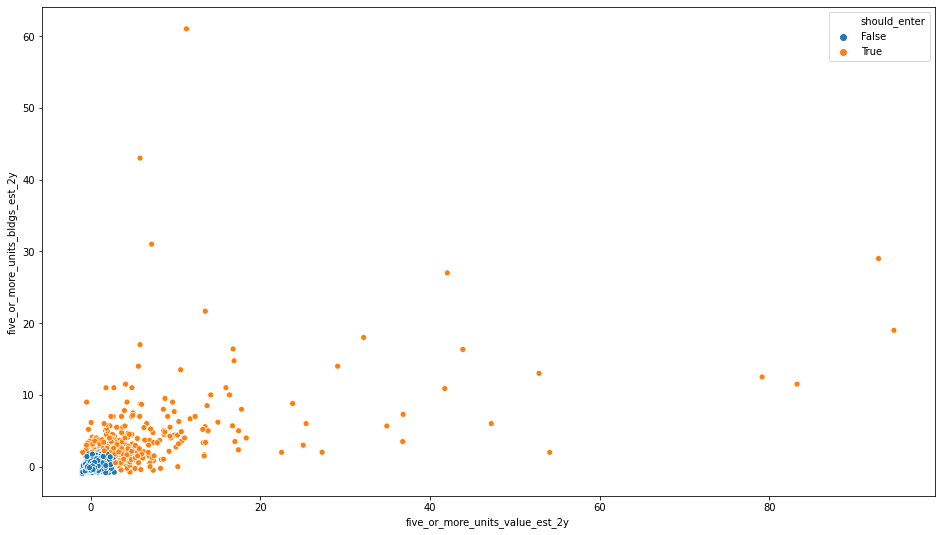

In [170]:
plt.figure(figsize=(16,9))
sns.scatterplot(x='five_or_more_units_value_est_2y', y='five_or_more_units_bldgs_est_2y', data=df_model, hue='should_enter')

In [188]:
(df_model[df_model.should_enter][df_model.five_or_more_units_value_est > df_model.five_or_more_units_value_est.quantile(.50)]).city.unique()

array(['Albany', 'Albuquerque', 'Anchorage', 'Atlanta', 'Austin',
       'Baltimore', 'Birmingham', 'Boston', 'Charleston', 'Charlotte',
       'Chicago', 'Cincinnati', 'Colorado Springs', 'Columbia',
       'Columbus', 'Denver', 'Des Moines', 'Detroit', 'El Paso', 'Fargo',
       'Fayetteville', 'Fort Collins', 'Greeley', 'Greensboro',
       'Greenville', 'Harrisburg', 'Hartford', 'Houston', 'Indianapolis',
       'Jacksonville', 'Kansas City', 'Lancaster', 'Las Vegas',
       'Lexington', 'Los Angeles', 'Louisville', 'Lubbock', 'Madison',
       'Memphis', 'Miami', 'Minneapolis', 'Myrtle Beach', 'Naples',
       'Nashville', 'New Haven', 'New Orleans', 'New York',
       'Oklahoma City', 'Omaha', 'Orlando', 'Philadelphia', 'Phoenix',
       'Pittsburgh', 'Portland', 'Raleigh', 'Reno', 'Richmond',
       'Riverside', 'Rochester', 'Sacramento', 'Salt Lake City',
       'San Antonio', 'San Diego', 'San Francisco', 'San Jose',
       'Santa Rosa', 'Seattle', 'Sioux Falls', 'Springfield'

In [179]:
df_model.five_or_more_units_value_est.describe()

count    2.990000e+03
mean     2.173416e+05
std      4.862564e+05
min      1.470000e+02
25%      1.679425e+04
50%      4.822950e+04
75%      1.664605e+05
max      8.471944e+06
Name: five_or_more_units_value_est, dtype: float64

In [ ]:
potential market value = 